In [1]:
"""
callejero.py

Matemática Discreta - IMAT
ICAI, Universidad Pontificia Comillas

Grupo: GP02A
Integrantes:
    - JAVIER ESCOBAR SERRANO
    - ENRIQUE FERNÁNDEZ-BAILLO RODRIÍGUEZ DE TEMBLEQUE

Descripción:
Librería con herramientas y clases auxiliares necesarias para la representación de un callejero en un grafo.

Complétese esta descripción según las funcionalidades agregadas por el grupo.
"""

#Constantes con las velocidades máximas establecidas por el enunciado para cada tipo de vía.
VELOCIDADES_CALLES={"AUTOVIA":100,"AVENIDA":90,"CARRETERA":70,"CALLEJON":30,"CAMINO":30,"ESTACION DE METRO":20,"PASADIZO":20,"PLAZUELA":20,"COLONIA":20}
VELOCIDAD_CALLES_ESTANDAR=50

import pandas as pd
from dgt import process_data
from grafo import Grafo
from math import sqrt
df_cruces, df_direcc = process_data("data/cruces.csv", "data/direcciones.csv")


class Cruce:

    #Completar esta clase con los datos y métodos que se necesite asociar a cada cruce

    def __init__(self,coord_x,coord_y):
        self.coord_x=coord_x
        self.coord_y=coord_y
        self.calles = self.get_calles(df_cruces)
    
    """Se hace que la clase Cruce sea "hashable" mediante la implementación de los métodos
    __eq__ y __hash__, haciendo que dos objetos de tipo Cruce se consideren iguales cuando
    sus coordenadas coincidan (es decir, C1==C2 si y sólo si C1 y C2 tienen las mismas coordenadas),
    independientemente de los otros campos que puedan estar almacenados en los objetos.
    La función __hash__ se adapta en consecuencia para que sólo dependa del par (coord_x, coord_y).
    """
    def __eq__(self,other) -> int:
        if type(other) is type(self):
            return ((self.coord_x==other.coord_x) and (self.coord_y==other.coord_y))
        else:
            return False
    
    def __hash__(self) -> int:
        return hash((self.coord_x,self.coord_y))

    def get_calles(self, cruces: pd.DataFrame):
        return cruces[cruces["coordenadas"] == (self.coord_x, self.coord_y)]["Codigo de vía tratado"].unique()
    

class Calle:
    #Completar esta clase con los datos que sea necesario almacenar de cada calle para poder reconstruir los datos del callejero
    def __init__(self, ID):
        self.ID = ID
        self.direcciones = self.get_data(df_cruces, df_direcc)[1]
        self.cruces = self.get_data(df_cruces, df_direcc)[0]

    def get_data(self, cruces: pd.DataFrame, direcciones: pd.DataFrame)-> tuple:
        return (cruces[cruces["Codigo de vía tratado"] == self.ID].coordenadas.unique(), direcciones[direcciones["Codigo de via"] == self.ID])

    def get_velocidad(self):
        if self.direcciones.empty or self.direcciones["Clase de la via"].iloc[0] not in VELOCIDADES_CALLES:
            return VELOCIDAD_CALLES_ESTANDAR
        else:
            return VELOCIDADES_CALLES[self.direcciones["Clase de la via"].iloc[0]]

def filtrar_por_radios(R: int):
    df_cruces["coordenadas"] = list(zip(df_cruces["Coordenada X (Guia Urbana) cm (cruce)"], df_cruces["Coordenada Y (Guia Urbana) cm (cruce)"]))
    coordenadas_a_tratar = sorted(df_cruces["coordenadas"].unique())
    coordenadas_limpias = []
    for coordenada in coordenadas_a_tratar:
        for x, y in coordenadas_limpias:
            if dist(coordenada, (x, y)) <= R:
                break
        else:
            coordenadas_limpias.append(coordenada)

    df_cruces["coordenadas"] = df_cruces["coordenadas"].apply(lambda x: x if x in coordenadas_limpias else closest(x, coordenadas_limpias, R))
    return coordenadas_limpias

def dist(coordenada1, coordenada2):
    return sqrt((coordenada1[0] - coordenada2[0])**2 + (coordenada1[1] - coordenada2[1])**2)

def closest(coordenada, coordenadas_limpias, R):
    coor_x, coor_y = coordenada[0], coordenada[1]
    for x, y in coordenadas_limpias:
        if (coor_x - R <= x <= coor_x + R) and (coor_y - R <= y <= coor_y + R):
            return (x, y)

if __name__ == "__main__":
    from time import time
    coordenadas_limpias = filtrar_por_radios(8000) # 8000 centímetros = 80 metros, se considera que un cruce está dentro del radio de otro si está a menos de 80 metros de distancia según las observaciones
    print(len(coordenadas_limpias))
    print(df_cruces["coordenadas"].head())

    # Creamos los cruces
    cruces = [Cruce(coordenada[0], coordenada[1]) for coordenada in coordenadas_limpias]

    # Creamos las calles
    calles = []
    for cruce in cruces: # Escogemos los cruces
        for calle in cruce.calles: # Escogemos las calles de cada cruce
            if calle not in calles: # Si la calle no está en la lista de calles, la añadimos
                calles.append(calle)  
    calles = [Calle(calle) for calle in calles] # Creamos los objetos calle

    # Creamos el grafo  
    grafo = Grafo(False)

    # Añadir vértices al grafo
    for cruce in cruces:
        grafo.agregar_vertice(cruce)
    
    # Para las aristas, se añaden las calles que conectan dos cruces como aristas del grafo
    for calle in calles:
        cruces_calle = calle.cruces
        for i in range(len(cruces_calle)):
            for j in range(i+1, len(cruces_calle)):
                grafo.agregar_arista(cruces_calle[i], cruces_calle[j])

    # Pasemoslo a networkx
    import networkx as nx
    import matplotlib.pyplot as plt
    G = grafo.convertir_a_NetworkX()

    pos = {}
    for cruce in cruces:
        pos[cruce] = (cruce.coord_x, cruce.coord_y)

c:\unibersida\segundo\discreta\practica1\Practica_3\dgt.py:40: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(path, encoding="iso-8859-1", delimiter=";")
c:\unibersida\segundo\discreta\practica1\Practica_3\dgt.py:94: FutureWarning: Returning a DataFrame from Series.apply when the supplied function returns a Series is deprecated and will be removed in a future version.
  literal_splitted[columnas] = literal_splitted['Literal de numeracion'].apply(lambda x: pd.Series(listas(x)))


7164
0    (44260732, 448479748)
1    (44260732, 448479748)
2    (44290433, 448494484)
3    (44320997, 448510385)
4    (44322285, 448530840)
Name: coordenadas, dtype: object


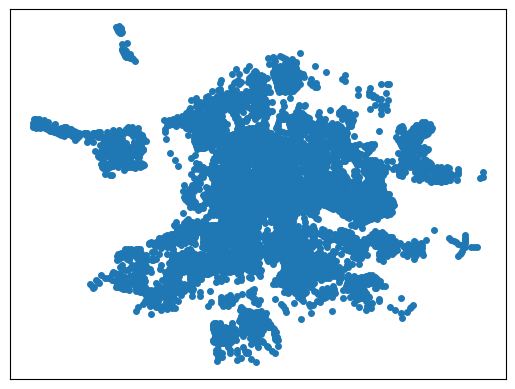

{<__main__.Cruce at 0x1f7dcbadb90>: {},
 <__main__.Cruce at 0x1f7dcbadcd0>: {},
 <__main__.Cruce at 0x1f7dcbafe10>: {},
 <__main__.Cruce at 0x1f7dcbad8d0>: {},
 <__main__.Cruce at 0x1f7dcbafb90>: {},
 <__main__.Cruce at 0x1f7dcbaec10>: {},
 <__main__.Cruce at 0x1f7dcbad650>: {},
 <__main__.Cruce at 0x1f7dcbacbd0>: {},
 <__main__.Cruce at 0x1f7dcbac810>: {},
 <__main__.Cruce at 0x1f7dcbafc10>: {},
 <__main__.Cruce at 0x1f7dcbadf10>: {},
 <__main__.Cruce at 0x1f7dcbad9d0>: {},
 <__main__.Cruce at 0x1f7dcbac0d0>: {},
 <__main__.Cruce at 0x1f7dcbaf310>: {},
 <__main__.Cruce at 0x1f7dcbaf090>: {},
 <__main__.Cruce at 0x1f7dcbadc90>: {},
 <__main__.Cruce at 0x1f7dcbae1d0>: {},
 <__main__.Cruce at 0x1f7dcbae190>: {},
 <__main__.Cruce at 0x1f7dcbaf010>: {},
 <__main__.Cruce at 0x1f7dcbacb50>: {},
 <__main__.Cruce at 0x1f7dcbad550>: {},
 <__main__.Cruce at 0x1f7dcbae690>: {},
 <__main__.Cruce at 0x1f7dcbae950>: {},
 <__main__.Cruce at 0x1f7dcbae2d0>: {},
 <__main__.Cruce at 0x1f7dcbad5d0>: {},


In [12]:
nx.draw_networkx_nodes(G, pos=pos, node_size=16)
nx.draw_networkx_edges(G, pos=pos, width=0.5, edge_color="black")
plt.show()
grafo.adyacencia